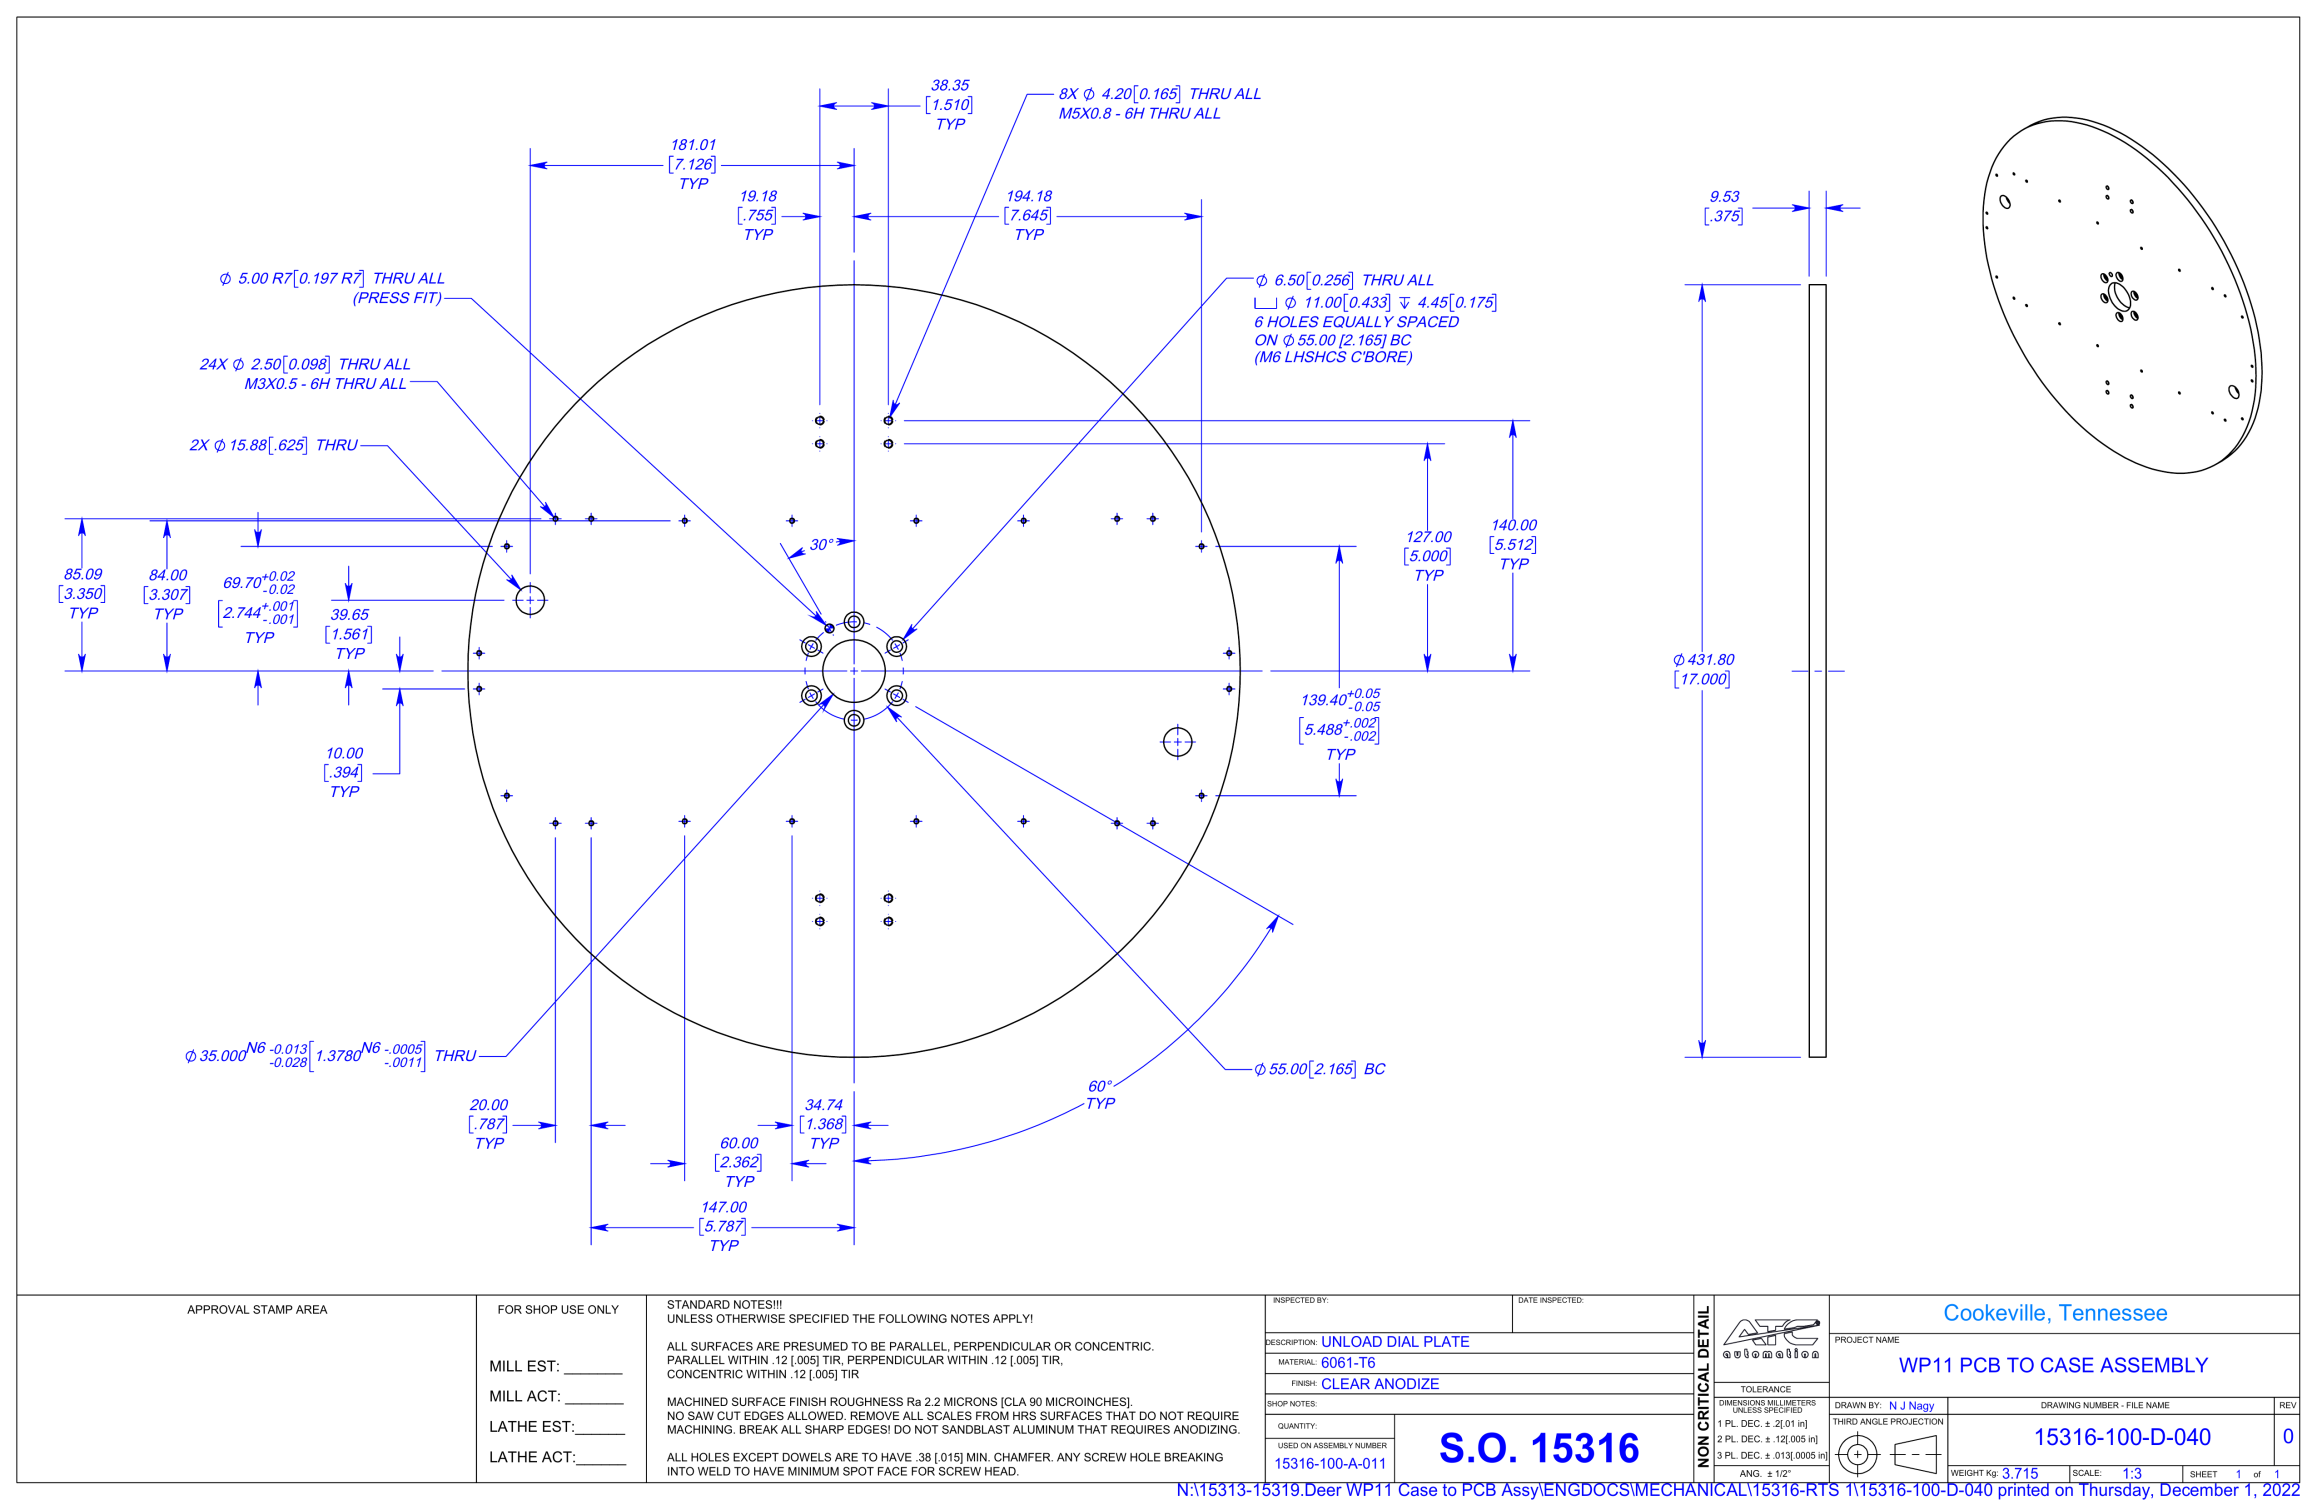

In [1]:
from glob import glob
import os

import cv2
import numpy as np
from PIL import Image
from pdf2image import convert_from_path
from imutils import resize
from sklearn.metrics import euclidean_distances
from tqdm import tqdm
from scoring import *
from border_and_title import *

# f = "../../data/original/Ugly/000.895.652.pdf"
# f = "../../data/original/Ugly/000.001.296.pdf"
# f = "../../data/original/Ugly/000.895.659.pdf"
# f = "../../data/original/Ugly/1.pdf"
f = "../../data/original/Good/15316-100-D-040_Sheet1.pdf"

font = cv2.FONT_HERSHEY_SIMPLEX
fontScale = 1
color = (255, 0, 0)
thickness = 2

pages = convert_from_path(f, dpi=300)
img = np.array(pages[0])
img = im_resize(img)
img_comp = img.copy()

Image.fromarray(img_comp)

[[[  18 1294 2299 1294]
  [  18   18 2299   18]
  [2299 1294 2299   18]
  [  18 1294   18   18]]

 [[  15 1500 2302 1500]
  [  15   15 2302   15]
  [2302 1500 2302   15]
  [  15 1500   15   15]]]
[[18, 1294], [2299, 18]] [18, 1294] [2299, 18]


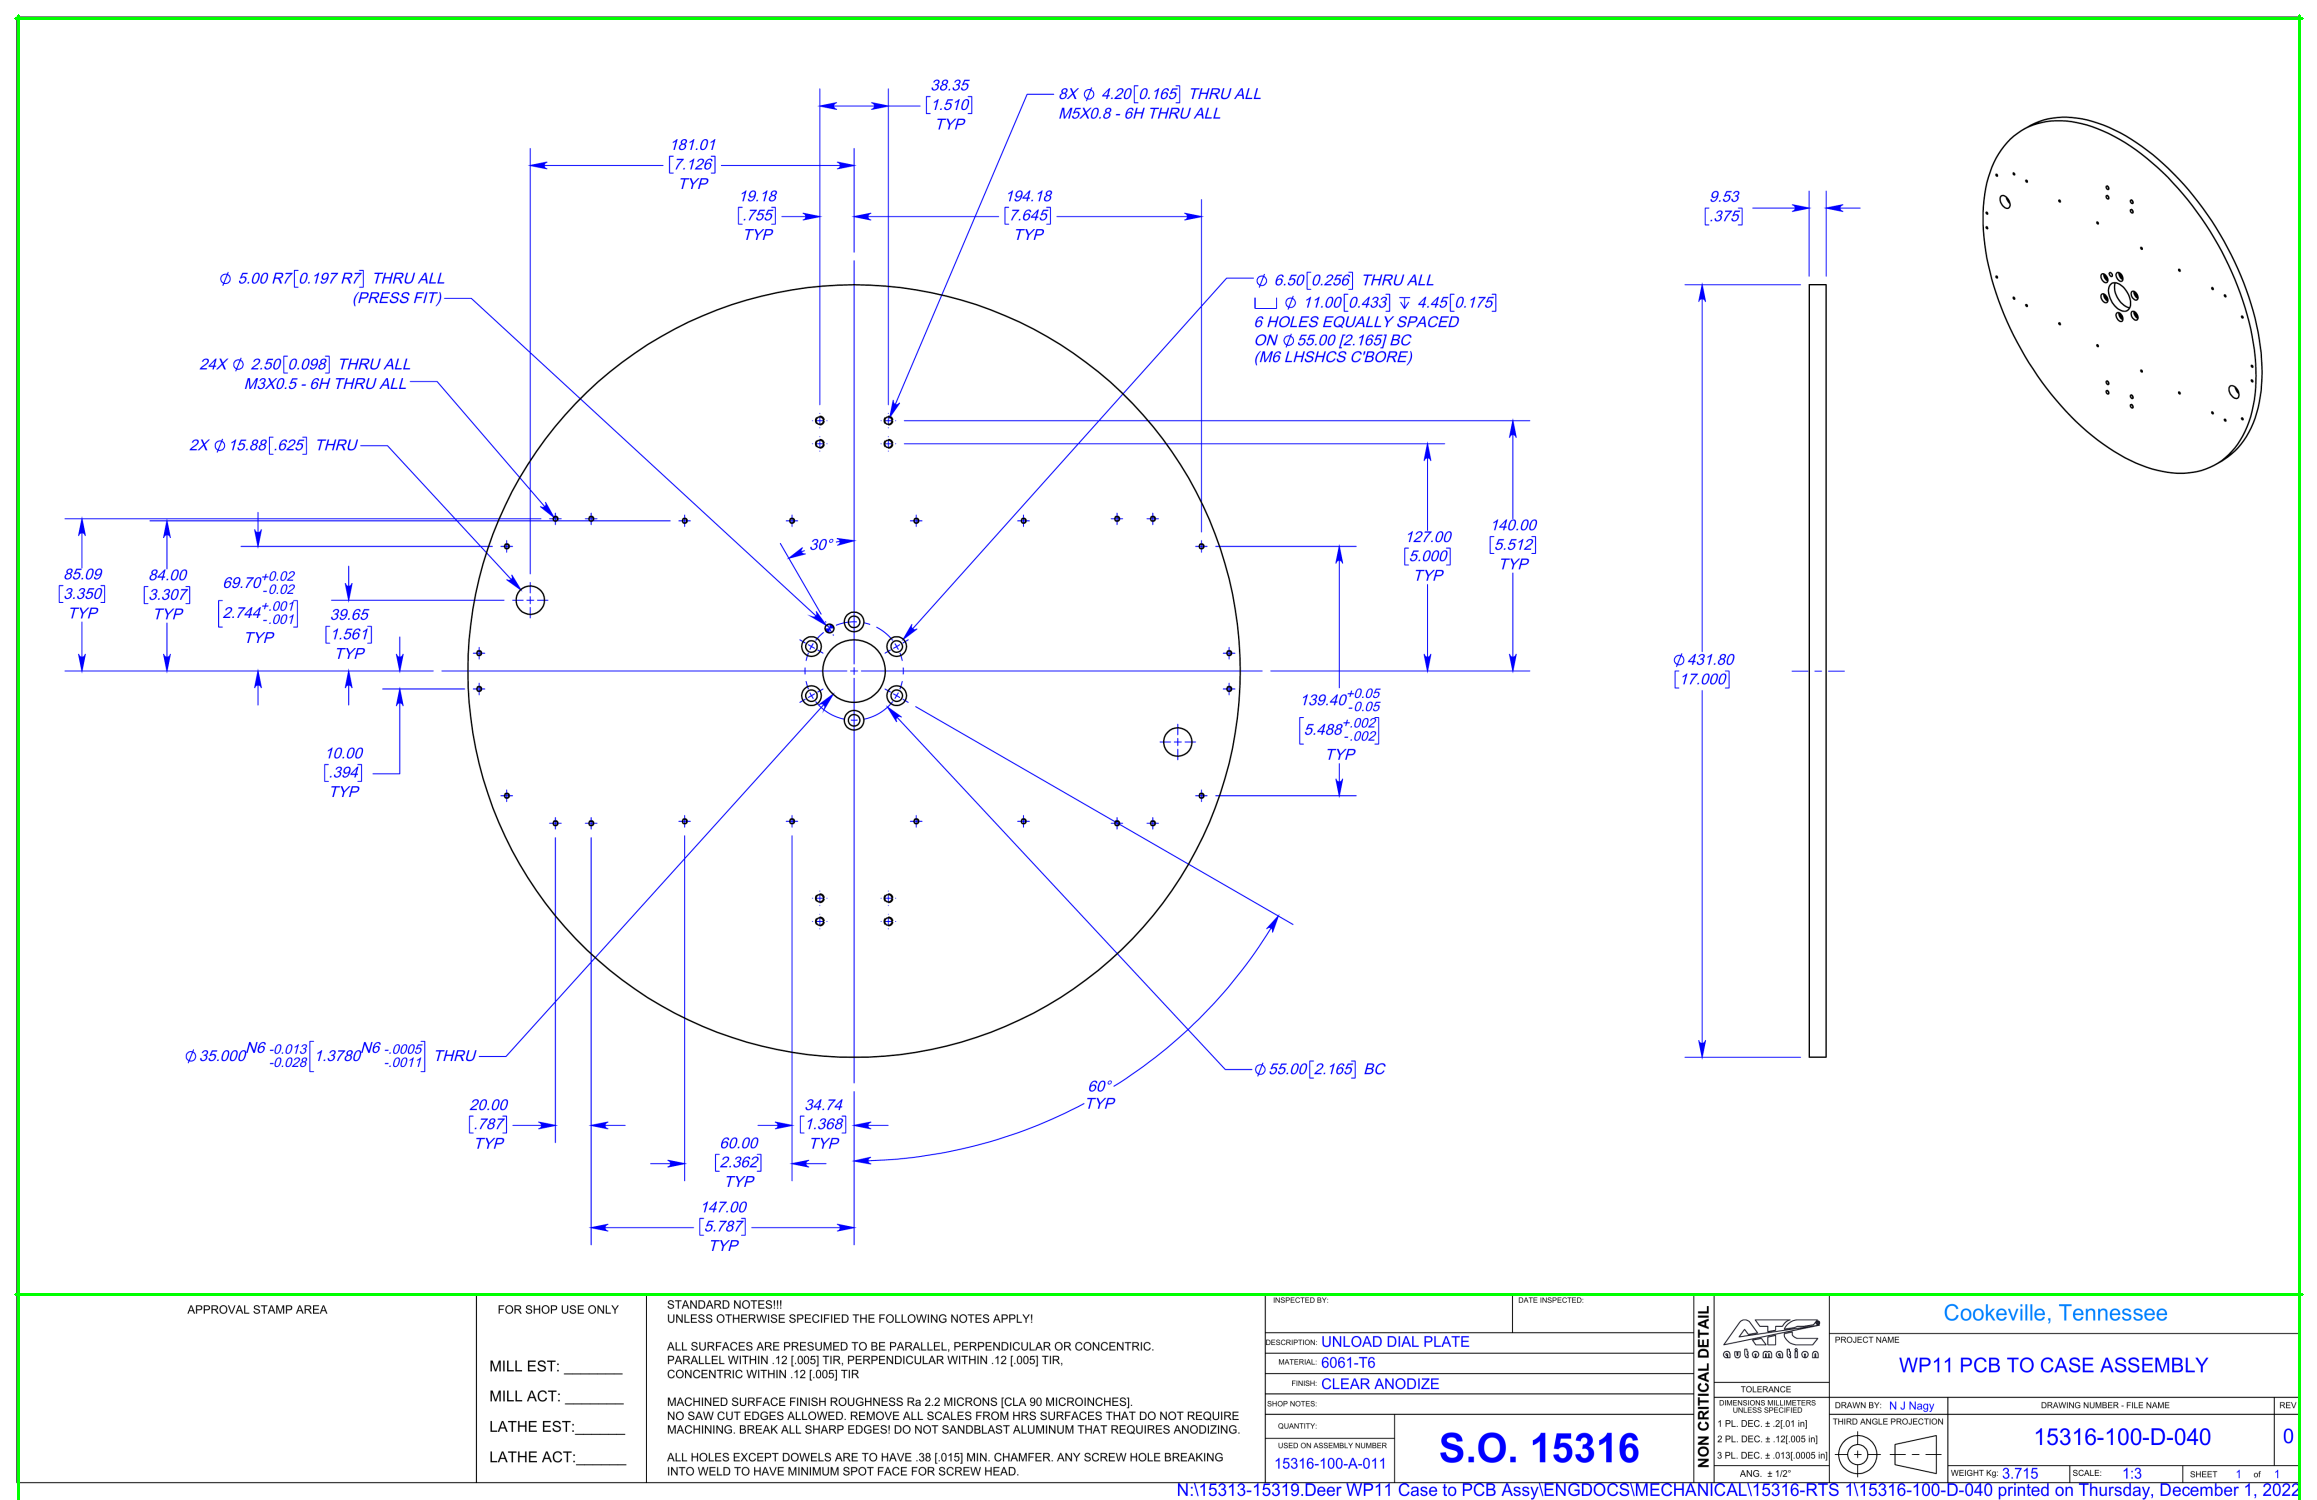

In [2]:
img_comp = img.copy()
im_h, im_w, _ = img.shape

sorted_indices, contours, hierarchy_area = detect_objects(img)
title_contours, line_90, data = detect_probable_title_sections(img, return_states=True)
ocr_result = data["ocr_result"]
mask = data["mask"]
inner_border_lines = data["inner_border_lines"]  #  0: Bottom, 1: Top, 2: Right, 3: Left
words = process_text(ocr_result, im_h, im_w)

border_1, border_2 = detect_borders(contours, sorted_indices, words)

(x1, y1), (x2, y2) = border_1
# cv2.rectangle(img_comp, (x1, y1), (x2, y2), color, thickness)
border_1_lines = [
    [x1, y2, x2, y2],  # Bottom
    [x1, y1, x2, y1],  # Top
    [x2, y2, x2, y1],  # Right
    [x1, y2, x1, y1],  # Left
]

(x1, y1), (x2, y2) = border_2
# cv2.rectangle(img_comp, (x1, y1), (x2, y2), color, thickness)
border_2_lines = [
    [x1, y2, x2, y2],  # Bottom
    [x1, y1, x2, y1],  # Top
    [x2, y2, x2, y1],  # Right
    [x1, y2, x1, y1],  # Left
]

all_lines = [
    border_2_lines,
    border_1_lines
]
if len(inner_border_lines) == 4:
    all_lines.append(inner_border_lines)

print(np.array(all_lines))

# for line in inner_border_lines:
#     x1, y1, x2, y2 = line
#     cv2.line(img_comp, (x1, y1), (x2, y2), (0, 255, 0), 5)

boundary = [[0, 0], [0, 0]]
for i, line in enumerate(zip(*all_lines)):
    line = np.array(line)
    # cv2.line(img_comp, (line[0][0], line[0][1]), (line[0][2], line[0][3]), (255, 0, 0), 1)
    # cv2.line(img_comp, (line[1][0], line[1][1]), (line[1][2], line[1][3]), (0, 255, 0), 1)
    if len(line) >= 3:
        cv2.line(img_comp, (line[2][0], line[2][1]), (line[2][2], line[2][3]), (0, 255, 0), 1)

    if i == 0:
        x1, y1, x2, y2 = line[:, 0].min(), line[:, 1].min(), line[:, 2].max(), line[:, 3].min()
        cv2.line(img_comp, (x1, y1), (x2, y2), (0, 255, 0), 2)
        boundary[0][1] = y1
    elif i == 1:
        x1, y1, x2, y2 = line[:, 0].min(), line[:, 1].max(), line[:, 2].max(), line[:, 3].max()
        cv2.line(img_comp, (x1, y1), (x2, y2), (0, 255, 0), 2)
        boundary[1][1] = y2
    elif i == 2:
        x1, y1, x2, y2 = line[:, 0].min(), line[:, 1].max(), line[:, 2].min(), line[:, 3].min()
        cv2.line(img_comp, (x1, y1), (x2, y2), (0, 255, 0), 2)
        boundary[1][0] = x2
    elif i == 3:
        x1, y1, x2, y2 = line[:, 0].max(), line[:, 1].max(), line[:, 2].max(), line[:, 3].min()
        cv2.line(img_comp, (x1, y1), (x2, y2), (0, 255, 0), 2)
        boundary[0][0] = x1


# cv2.rectangle(img_comp, boundary[0], boundary[1], (255, 0, 0), 3)
print(boundary, boundary[0], boundary[1])
Image.fromarray(img_comp)

(18, 1294) (2299, 1294)
[[18, 1294], [2299, 18]]


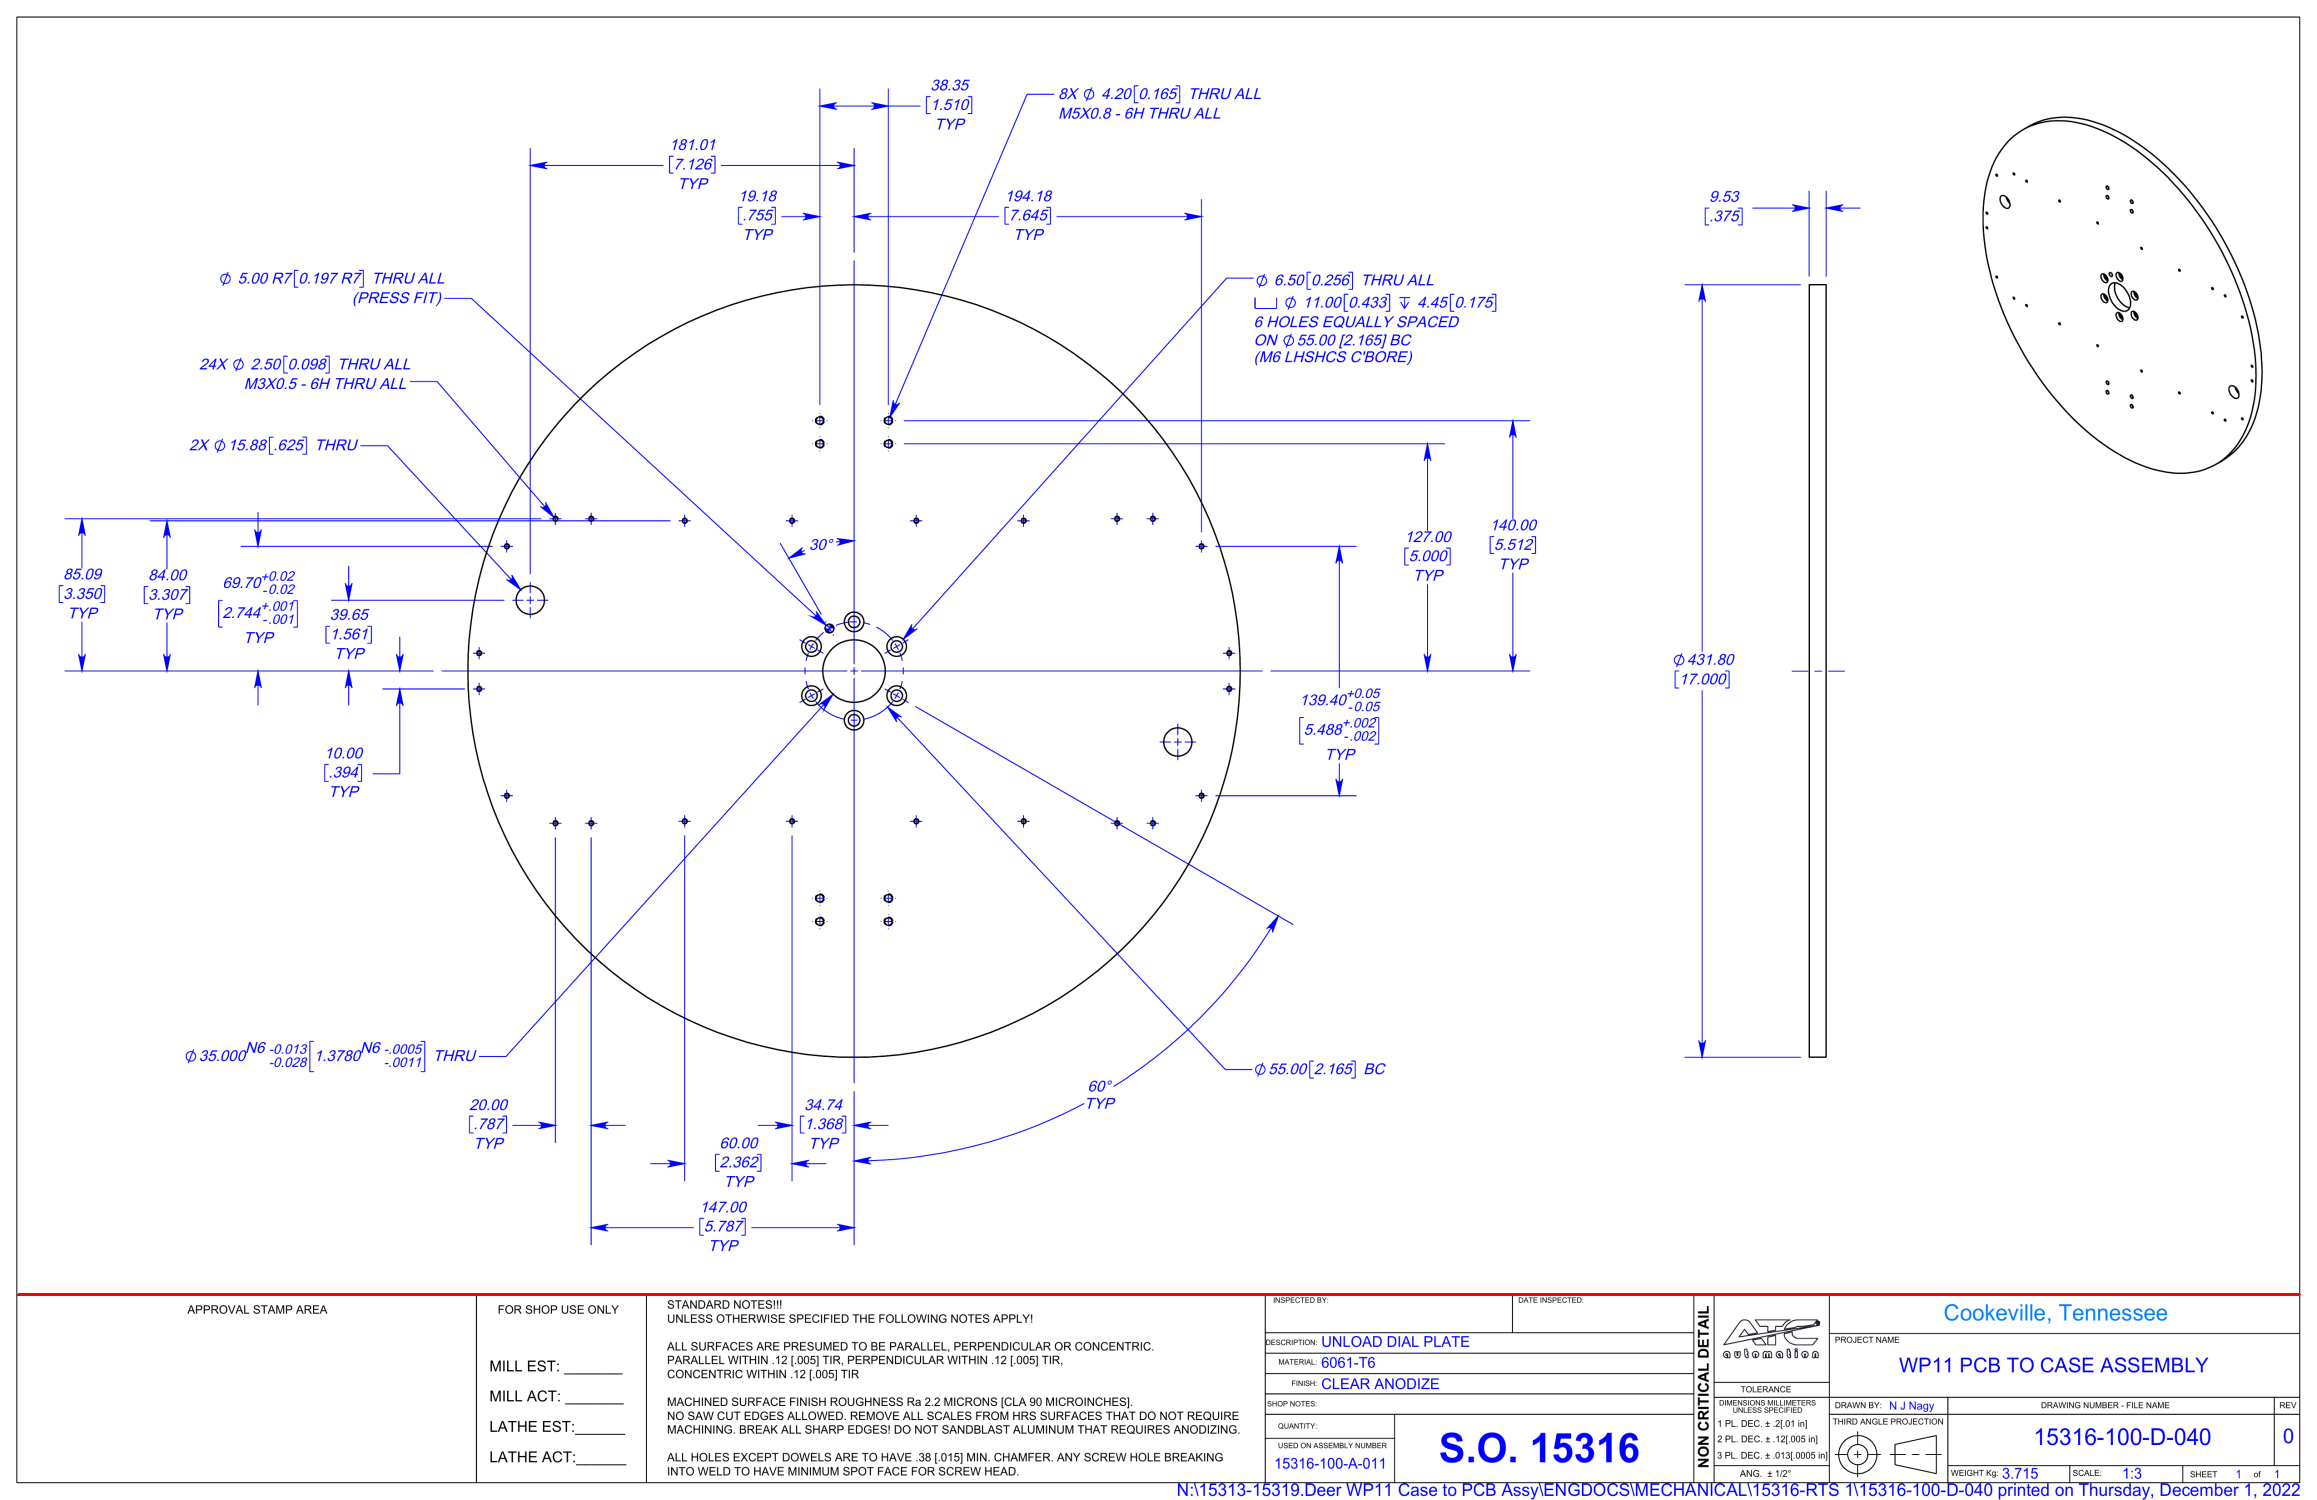

In [3]:
img_comp = img.copy()
contours = detect_text_tables(img, words, mask)
title_contours = title_contours + contours

bb = []
for cnt in title_contours:
    x, y, w, h = cv2.boundingRect(cnt)
    x1 = x + w
    y1 = y + h
    aspect_ratio = w / float(h)
    area = w * h

    if area > 7000 and 1.3 < aspect_ratio < 10:
        ratio = table_content_score(((x, y), (x1, y1)), words)

        if ratio <= 1:
            if y > int((im_h * 70) / 100) and y+h > int((im_h * 93) / 100):
                bb.append((x, y, x1, y1))

            elif y > int((im_h * 80) / 100) and y1 > int((im_h * 90) / 100):
                bb.append((x, y, x1, y+h))
try:
    bb = np.array(bb)

    if line_90 is not None:
        x1, y1, x2, y2 = line_90
        x1 = boundary[0][0]
        x2 = boundary[1][0]
    else:
        x2 = bb[:, 2].max()
        x1 = bb[:, 0].min()
        y1 = bb[:, 1].min()

        if abs(boundary[1][0] - bb[:, 2].max()) < 50:
            x2 = boundary[1][0]

        if abs(boundary[0][0] - bb[:, 0].min()) < 50:
            x1 = boundary[0][0]

    y2 = max(boundary[0][1], boundary[1][1])

    print((x1, y1), (x2, y2))
    print(boundary)
    cv2.rectangle(img_comp, (x1, y1), (x2, y2), color, thickness)
except IndexError:
    print(f)
    print(bb)


# "../../data/original/Ugly/000.895.659.pdf"
# (1109, 1240) (2070, 51)
# [[51, 51], [2070, 1450]]

#f = "../../data/original/Ugly/000.001.296.pdf"
# (1109, 1241) (2070, 1449)
# [[51, 1449], [2070, 51]]
Image.fromarray(img_comp)